# Self-Driving Car Engineer Nanodegree


## Project: **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note: If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".**

---

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="examples/line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="examples/laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

**Run the cell below to import some packages.  If you get an `import error` for a package you've already installed, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt.  Also, consult the forums for more troubleshooting tips.**  

## Import Packages

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import glob
import math
from scipy import interpolate
%matplotlib inline

## Read in an Image

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


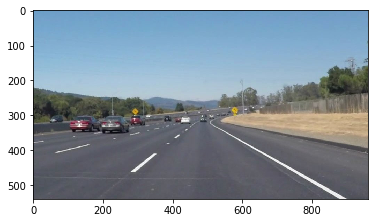

In [2]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteCurve.jpg')
#image = cv2.imread('test_images/solidWhiteCurve.jpg')

#printing out some stats and plotting
print('This image is:', type(image), 'with dimensions:', image.shape)
plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

## Helper Functions

Below are some helper functions.

In [3]:
import math

def draw_lines_connected(img, lines, color=[255, 0, 0], thickness=8):
    x_size = img.shape[1]
    y_size = img.shape[0]
    lines_slope_intercept = np.zeros(shape=(len(lines),2))
    for index,line in enumerate(lines):        
        for x1,y1,x2,y2 in line:
            slope = (y2-y1)/(x2-x1)
            intercept = y1 - x1 * slope
            lines_slope_intercept[index]=[slope,intercept]
    max_slope_line = lines_slope_intercept[lines_slope_intercept.argmax(axis=0)[0]]
    min_slope_line = lines_slope_intercept[lines_slope_intercept.argmin(axis=0)[0]]
    left_slopes = []
    left_intercepts = []
    right_slopes = []
    right_intercepts = []
    # this gets slopes and intercepts of lines similar to the lines with the max (immediate left) and min
    # (immediate right) slopes (i.e. slope and intercept within x%)
    for line in lines_slope_intercept:
        if abs(line[0] - max_slope_line[0]) < 0.15 and abs(line[1] - max_slope_line[1]) < (0.15 * x_size):
            left_slopes.append(line[0])
            left_intercepts.append(line[1])
        elif abs(line[0] - min_slope_line[0]) < 0.15 and abs(line[1] - min_slope_line[1]) < (0.15 * x_size):
            right_slopes.append(line[0])
            right_intercepts.append(line[1])
    # left and right lines are averages of these slopes and intercepts, extrapolate lines to edges and center*
    # *roughly
    new_lines = np.zeros(shape=(1,2,4), dtype=np.int32)
    if len(left_slopes) > 0:
        left_line = [sum(left_slopes)/len(left_slopes),sum(left_intercepts)/len(left_intercepts)]
        left_bottom_x = (y_size - left_line[1])/left_line[0]
        left_top_x = (y_size*.575 - left_line[1])/left_line[0]
        if (left_bottom_x >= 0):
            new_lines[0][0] =[left_bottom_x,y_size,left_top_x,y_size*.575]
    if len(right_slopes) > 0:
        right_line = [sum(right_slopes)/len(right_slopes),sum(right_intercepts)/len(right_intercepts)]
        right_bottom_x = (y_size - right_line[1])/right_line[0]
        right_top_x = (y_size*.575 - right_line[1])/right_line[0]
        if (right_bottom_x <= x_size):
            new_lines[0][1]=[right_bottom_x,y_size,right_top_x,y_size*.575]
    for line in new_lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)

def hsv(img):
    return cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
            
def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[255, 0, 0], thickness=8):    
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)
    
    
    
def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    # Draw normal lines which are not connected
    # draw_lines(line_img, lines)
    # Draw connected lines
    draw_lines_connected(line_img, lines)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=1.0, β=0.8, λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

## Build a Lane Finding Pipeline



In [4]:
def process_image(image):
    gray_img = grayscale(image)    
    hsv_img = hsv(image)
    
    # define range of color in HSV
    lower_yel = np.array([20,100,100])
    upper_yel = np.array([30,255,255])
    lower_wht = np.array([0,0,235])
    upper_wht = np.array([255,255,255])
    
    # Threshold the HSV image to get only yellow/white 
    yellow_mask = cv2.inRange(hsv_img, lower_yel, upper_yel)
    white_mask = cv2.inRange(hsv_img, lower_wht, upper_wht)
    # Bitwise-AND mask and original image
    full_mask = cv2.bitwise_or(yellow_mask, white_mask)
    
    subdued_gray = (gray_img / 2).astype('uint8')
    
    boosted_lanes = cv2.bitwise_or(subdued_gray, full_mask)

    kernel_size = 5
    blurred_img = gaussian_blur(boosted_lanes,kernel_size)
    
    canny_low_threshold = 60
    canny_high_threshold = 150
    edges_img = canny(blurred_img,canny_low_threshold,canny_high_threshold)
    
    x = edges_img.shape[1]
    y = edges_img.shape[0]
    vertices = np.array([[(x*0.,y),(x*.475, y*.575), (x*.525, y*.575), (x,y)]], dtype=np.int32)
    masked_img = region_of_interest(edges_img, vertices)
    
    hough_rho = 3
    hough_theta = np.pi/180
    hough_threshold = 70
    hough_min_line_length = 70
    hough_max_line_gap = 250
    hough_img = hough_lines(masked_img,hough_rho,hough_theta,hough_threshold,hough_min_line_length,hough_max_line_gap)
    
    result = weighted_img(hough_img,image)
    
    #return cv2.cvtColor(masked_img, cv2.COLOR_GRAY2RGB)
    return result

## Test Images

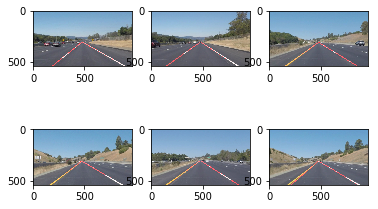

In [5]:
paths = glob.glob('test_images/*.jpg')

for i,image_path in enumerate(paths):
    image = mpimg.imread(image_path)
    result = process_image(image)
    plt.subplot(2,3,i+1)
    plt.imshow(result)
    mpimg.imsave('test_images/marked/'+image_path[12:-4]+'_detected.png', result)

## Test on Videos

In [6]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

Let's try the one with the solid white lane on the right first ...

In [7]:
white_output = 'test_videos_output/solidWhiteRight.mp4'
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image)
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/solidWhiteRight.mp4
[MoviePy] Writing video test_videos_output/solidWhiteRight.mp4


100%|█████████▉| 221/222 [00:12<00:00, 17.33it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidWhiteRight.mp4 

CPU times: user 12.6 s, sys: 588 ms, total: 13.2 s
Wall time: 13.4 s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [8]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [9]:
yellow_output = 'test_videos_output/solidYellowLeft.mp4'
clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/solidYellowLeft.mp4
[MoviePy] Writing video test_videos_output/solidYellowLeft.mp4


100%|█████████▉| 681/682 [00:36<00:00, 18.48it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidYellowLeft.mp4 

CPU times: user 38.8 s, sys: 1.09 s, total: 39.9 s
Wall time: 38.5 s


In [10]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Optional Challenge

In [11]:
challenge_output = 'test_videos_output/challenge.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip3 = VideoFileClip('test_videos/challenge.mp4').subclip(0,5)
clip3 = VideoFileClip('test_videos/challenge.mp4')
challenge_clip = clip3.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/challenge.mp4
[MoviePy] Writing video test_videos_output/challenge.mp4


100%|██████████| 251/251 [00:25<00:00,  9.96it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/challenge.mp4 

CPU times: user 22 s, sys: 736 ms, total: 22.7 s
Wall time: 28.1 s


In [12]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))